In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
import os
import PIL
import PIL.Image
from pathlib import Path

In [2]:
def plot_classification(y_true, y_pred):
    target_names = searches
    labels_names = [0, 1] 
    print(classification_report(y_true, y_pred,labels=labels_names, target_names=target_names))    
    cm = confusion_matrix(y_true, y_pred,labels=labels_names)  #, normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [32]:
searches = 'queens', 'workers'
data_dir = Path('bee_recognition\images')

#### Transfer learning with Tensorflow

In [22]:
import glob as gb

In [33]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1604


In [37]:
IMG_SIZE = (160, 160)

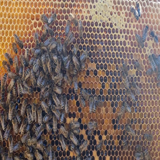

In [38]:
queen = list(data_dir.glob('queens/*'))
im = PIL.Image.open(str(queen[1]))
im.resize(IMG_SIZE)

In [42]:
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    crop_to_aspect_ratio=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    crop_to_aspect_ratio=True)

test_dataset = val_ds.take(2)
val_ds = val_ds.skip(2)

print('Batches for testing -->', test_dataset.cardinality())
print('Batches for validating -->', val_ds.cardinality())

Found 1604 files belonging to 2 classes.
Using 1203 files for training.
Found 1604 files belonging to 2 classes.
Using 320 files for validation.
Batches for testing --> tf.Tensor(2, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(8, shape=(), dtype=int64)


In [43]:
class_names = train_ds.class_names
print(class_names)

['queens', 'workers']


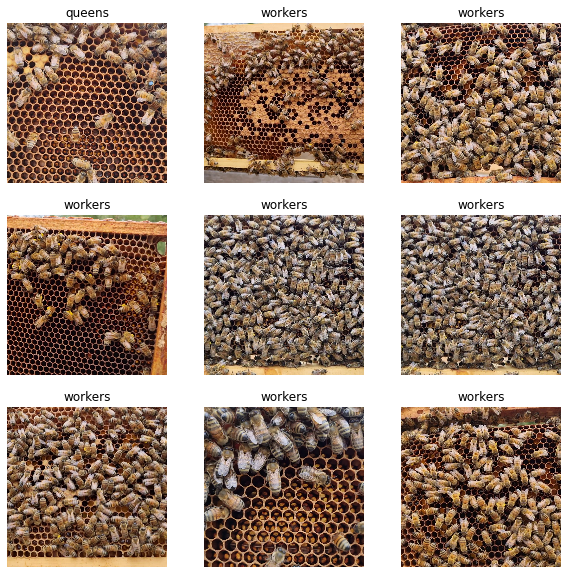

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#### Configure the dataset for performance

In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

#### Create the base model from the pre-trained convnets

In [48]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

early_stopping_monitor = EarlyStopping(patience=7, restore_best_weights=True)

total_epochs = 100

In [49]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

    base_model.trainable = True

    # Let's take a look to see how many layers are in the base model
    # print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 140

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # # Add a classification head
    # image_batch, label_batch = next(iter(train_ds))
    # feature_batch = base_model(image_batch)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # feature_batch_average = global_average_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(1)
    # prediction_batch = prediction_layer(feature_batch_average)
    # print(prediction_batch.shape)

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/25),
                metrics=['accuracy'])

    return model

In [50]:
model = create_model()

model.summary()

9420800/9406464 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                

In [51]:
history = model.fit(train_ds, epochs=total_epochs, verbose=True, 
                    validation_data=val_ds, callbacks = [early_stopping_monitor])

Epoch 1/100
38/38 [==============================] - 30s 666ms/step - loss: 0.3916 - accuracy: 0.8221 - val_loss: 0.4057 - val_accuracy: 0.8281
Epoch 2/100
38/38 [==============================] - 20s 531ms/step - loss: 0.2484 - accuracy: 0.9052 - val_loss: 0.3255 - val_accuracy: 0.8477
Epoch 3/100
38/38 [==============================] - 19s 494ms/step - loss: 0.2058 - accuracy: 0.9302 - val_loss: 0.2797 - val_accuracy: 0.8672
Epoch 4/100
38/38 [==============================] - 19s 506ms/step - loss: 0.1766 - accuracy: 0.9352 - val_loss: 0.2529 - val_accuracy: 0.8867
Epoch 5/100
38/38 [==============================] - 21s 552ms/step - loss: 0.1739 - accuracy: 0.9393 - val_loss: 0.2406 - val_accuracy: 0.9023
Epoch 6/100
38/38 [==============================] - 19s 489ms/step - loss: 0.1551 - accuracy: 0.9435 - val_loss: 0.2219 - val_accuracy: 0.9141
Epoch 7/100
38/38 [==============================] - 16s 432ms/step - loss: 0.1402 - accuracy: 0.9460 - val_loss: 0.2137 - val_accuracy:

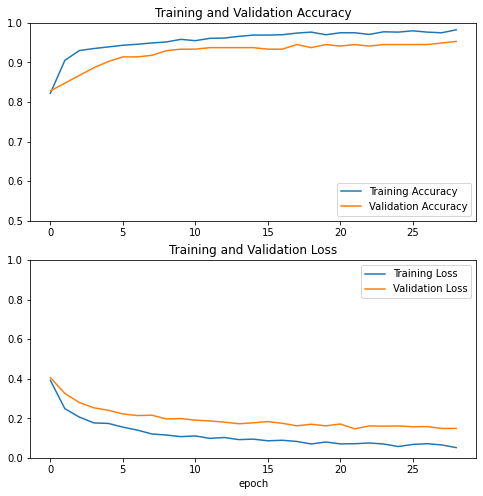

In [52]:
plot_history(history)

In [53]:
# Save the weights using the `checkpoint_path` format
latest = 'model.ckpt'
model.save_weights(latest)

In [54]:
# should prepare an actual test set with images instead
test_ds = test_dataset

In [55]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Evaluation and prediction
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2/2 - 3s - loss: 0.1802 - accuracy: 0.9531 - 3s/epoch - 1s/step
Restored model, accuracy: 95.31%


Predictions:
 [1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1]
Labels:
 [1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1]


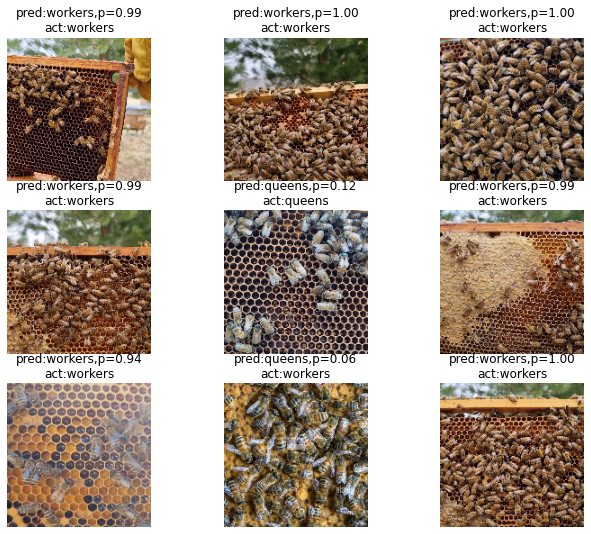

In [56]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions_prob = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions_prob < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(11, 9))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'pred:{class_names[predictions[i]]},p={predictions_prob[i]:0.2f}\nact:{class_names[label_batch[i]]}')
  plt.axis("off")